# Figure 4.1 - LinClass7

In [1]:
import sys 
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)

In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3

In [2]:
%%R -w 8 -h 4 --units in -r 200
require("survival")
library(tidyverse)
library(ggpubr)
library(survminer)

R[write to console]: Loading required package: survival

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Fractions

In [3]:
celltypes = ['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']#, 'B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry']

def process_fractions(adata, res=0.5, cohort = 'TCGA'):
    adata = adata[:,~adata.var_names.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
    adata.X = (adata.X.transpose() / adata.X.sum(axis=1)).transpose()

    sc.pp.pca(adata, n_comps=5)
    sc.pp.neighbors(adata, n_neighbors=10)
    sc.tl.leiden(adata, resolution = res)
    sc.tl.umap(adata)
    
    sc.pl.pca(adata, color=['leiden']+celltypes, color_map = 'RdBu_r', wspace = 0.3, ncols=4)
    
    return(adata)

In [4]:
cat = sc.read_h5ad("Data/Hierarchy_Reference_3Cohorts.h5ad")
cat.obs = href.obs.join(href.to_df())
cat

AnnData object with n_obs × n_vars = 864 × 7
    obs: 'Cohort', 'Cluster', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3', 'GMP-like', 'LSPC-Cycle', 'LSPC-Primed', 'LSPC-Quiescent', 'Mono-like', 'ProMono-like', 'cDC-like'
    var: 'NMF1', 'NMF2', 'NMF3'
    uns: 'Cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Regress on PC2

In [11]:
# TCGA Expression - CPM
tcga_expr = sc.read_csv("Data/Fig4_DrugResponse_LinClass7/LinClass7_Training/TCGA_LAML_CPM.txt", delimiter='\t').T
tcga_expr.obs.index = [x[0:12] for x in tcga_expr.obs.index]
tcga_expr.obs = tcga_expr.obs.merge(cat[cat.obs['Cohort'] == 'TCGA'].obs[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3', 
                                                                          'LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']], 
                                    how='left', left_index=True, right_index=True)
sc.pp.log1p(tcga_expr)

# BEAT Expression - CPM
beat_expr = sc.read_csv("Data/Fig4_DrugResponse_LinClass7/LinClass7_Training/BEAT_AML_CPM.txt", delimiter='\t').T
beat_expr = beat_expr[beat_expr.obs.index.isin(cat[cat.obs['Cohort'] == 'BEAT'].obs.index)]
beat_expr.obs = beat_expr.obs.merge(cat[cat.obs['Cohort'] == 'BEAT'].obs[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3', 
                                                                          'LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']], 
                                    how='left', left_index=True, right_index=True)
sc.pp.log1p(beat_expr)

# Leucegene Expression - CPM
leuc_expr = sc.read_csv("Data/Fig4_DrugResponse_LinClass7/LinClass7_Training/Leucegene_CPM.txt", delimiter='\t').T
leuc_expr.obs.index = [x[1] for x in leuc_expr.obs.index.str.split('_')]
leuc_expr.obs = leuc_expr.obs.merge(cat[cat.obs['Cohort'] == 'Leucegene'].obs[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3', 
                                                                          'LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']], 
                                    how='left', left_index=True, right_index=True)
sc.pp.log1p(leuc_expr)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Expression

In [12]:
lsc17_pos = ['DNMT3B', 'GPR56', 'NGFRAP1', 'CD34', 'DPYSL3', 'SOCS2', 'MMRN1', 'KIAA0125', 'EMP1', 'NYNRIN', 'LAPTM4B']
lsc17_neg = ['CDK6', 'AKR1C3', 'ZBTB46', 'CPXM1', 'C19orf77', 'ARHGAP22']

### Make Correlation Matrix

In [14]:
for gene in ['DNMT3B', 'GPR56', 'NGFRAP1', 'CD34', 'DPYSL3', 'SOCS2', 'MMRN1', 'KIAA0125', 'EMP1', 'NYNRIN', 'LAPTM4B', 'CDK6', 'AKR1C3', 'ZBTB46', 'CPXM1', 'ARHGAP22']:
    leuc_expr.obs[gene] = leuc_expr.X[:,leuc_expr.var_names == gene]

In [15]:
for gene in (lsc17_pos + lsc17_neg):
    tcga_expr.obs[gene] = tcga_expr.X[:,tcga_expr.var_names == gene]
    beat_expr.obs[gene] = beat_expr.X[:,beat_expr.var_names == gene]

In [16]:
tcga_lsc17_corr = tcga_expr.obs[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle',
                                 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like',
                                'DNMT3B', 'GPR56', 'NGFRAP1', 'CD34', 'DPYSL3', 'SOCS2', 'MMRN1', 'KIAA0125', 'EMP1', 'NYNRIN', 'LAPTM4B', 
                                'CDK6', 'AKR1C3', 'ZBTB46', 'CPXM1', 'C19orf77', 'ARHGAP22']].corr()
tcga_lsc17_corr = tcga_lsc17_corr.iloc[tcga_lsc17_corr.index.str.contains('-'),:].iloc[:,~tcga_lsc17_corr.index.str.contains('-')]
tcga_lsc17_corr.style.background_gradient(cmap='coolwarm')

,DNMT3B,GPR56,NGFRAP1,CD34,DPYSL3,SOCS2,MMRN1,KIAA0125,EMP1,NYNRIN,LAPTM4B,CDK6,AKR1C3,ZBTB46,CPXM1,C19orf77,ARHGAP22
LSPC-Quiescent,0.463796,0.514835,0.390562,0.443083,0.293781,0.217941,0.420640,0.584693,0.257827,0.444925,0.375017,0.170277,0.408291,0.533384,0.372248,0.433781,0.491029
LSPC-Primed,0.428765,0.379797,0.255063,0.280523,0.235284,0.342194,0.452182,0.562042,0.202092,0.386629,0.383875,0.520122,0.388167,0.536106,0.307907,0.263412,0.367095
LSPC-Cycle,0.297777,0.240567,0.223900,0.226021,-0.052211,0.209661,0.378274,0.382728,0.012408,0.218267,0.328100,0.224662,0.242842,0.104746,0.095990,0.017702,0.139127
GMP-like,-0.030610,-0.202586,-0.195101,-0.040403,-0.209125,-0.185076,-0.346381,-0.470580,0.030167,-0.119539,-0.136649,0.302505,0.036734,-0.135847,0.162817,0.357138,-0.324686
ProMono-like,-0.061892,-0.174701,0.074121,-0.493347,-0.048469,0.002473,-0.213705,-0.293336,-0.374807,-0.115641,0.019285,-0.139812,-0.346224,-0.364121,-0.149540,-0.293224,-0.036990
Mono-like,-0.579804,-0.354157,-0.285105,-0.144149,-0.095211,-0.226375,-0.225679,-0.218790,-0.099290,-0.458450,-0.392143,-0.593895,-0.419394,-0.398652,-0.503617,-0.549589,-0.225237
cDC-like,-0.304931,-0.169091,-0.194864,-0.317464,0.043841,-0.123244,-0.149044,-0.162646,-0.122535,-0.132665,-0.318519,-0.535059,-0.277487,-0.133422,-0.289141,-0.420383,-0.097748


In [17]:
beat_lsc17_corr = beat_expr.obs[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle',
                                 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like',
                                'DNMT3B', 'GPR56', 'NGFRAP1', 'CD34', 'DPYSL3', 'SOCS2', 'MMRN1', 'KIAA0125', 'EMP1', 'NYNRIN', 'LAPTM4B', 
                                'CDK6', 'AKR1C3', 'ZBTB46', 'CPXM1', 'C19orf77', 'ARHGAP22']].corr()
beat_lsc17_corr = beat_lsc17_corr.iloc[beat_lsc17_corr.index.str.contains('-'),:].iloc[:,~beat_lsc17_corr.index.str.contains('-')]
beat_lsc17_corr.style.background_gradient(cmap='coolwarm')

,DNMT3B,GPR56,NGFRAP1,CD34,DPYSL3,SOCS2,MMRN1,KIAA0125,EMP1,NYNRIN,LAPTM4B,CDK6,AKR1C3,ZBTB46,CPXM1,C19orf77,ARHGAP22
LSPC-Quiescent,0.530881,0.559954,0.316357,0.421880,0.324640,0.324002,0.388049,0.648535,0.136568,0.465945,0.323778,0.429727,0.496573,0.679694,0.420108,0.577417,0.380096
LSPC-Primed,0.422873,0.400058,0.359817,0.174017,0.344433,0.339721,0.235009,0.516882,0.009486,0.185473,0.307992,0.220354,0.330134,0.491657,0.354845,0.333221,0.348620
LSPC-Cycle,0.299276,0.221841,0.155294,0.086238,-0.001952,0.287589,0.304725,0.221888,-0.130501,0.241929,0.223156,0.143130,0.217308,0.056660,0.058562,0.063213,0.148354
GMP-like,0.009299,-0.140349,-0.026764,0.055443,-0.097010,-0.178264,-0.259541,-0.189757,0.089961,-0.041932,0.049972,0.302430,0.188232,-0.119984,0.322136,0.332319,-0.154595
ProMono-like,-0.145409,-0.338145,-0.019595,-0.452781,-0.117739,-0.101073,-0.225675,-0.406990,-0.156657,-0.168500,-0.037296,-0.012367,-0.309866,-0.355945,-0.268974,-0.403883,-0.119539
Mono-like,-0.546315,-0.335693,-0.251041,-0.183391,-0.183126,-0.380905,-0.202051,-0.386882,-0.091772,-0.426891,-0.335170,-0.710673,-0.413709,-0.426402,-0.448295,-0.520811,-0.228073
cDC-like,-0.482253,-0.313535,-0.403782,-0.249413,-0.192218,-0.136229,-0.121654,-0.328906,0.010417,-0.240361,-0.445092,-0.447275,-0.582342,-0.304202,-0.572037,-0.588640,-0.247699


## Regression using LSC17 genes

In [428]:
# C19orf77 is not found in leucegene
lsc17_genes = ['DNMT3B', 'GPR56', 'NGFRAP1', 'CD34', 'DPYSL3', 'SOCS2', 'MMRN1', 'KIAA0125', 'EMP1', 
               'NYNRIN', 'LAPTM4B', 'CDK6', 'AKR1C3', 'ZBTB46', 'CPXM1', 'ARHGAP22']#, 'C19orf77']

### Build LASSO Regressor

Train on TCGA and Leucegene datasets, validate on BEAT-AML

In [429]:
tcga_leuc_cat_obs = tcga_expr.obs.append(leuc_expr.obs).dropna()
tcga_leuc_cat_obs.head()

,PC1,PC2,PC3,PC4,PC5,PC6,NMF1,NMF2,NMF3,LSPC-Quiescent,...,KIAA0125,EMP1,NYNRIN,LAPTM4B,CDK6,AKR1C3,ZBTB46,CPXM1,C19orf77,ARHGAP22
TCGA-AB-2803,0.315948,0.053389,-0.097422,0.100484,0.063278,-0.074975,0.419315,1.762287,0.403242,0.083605,...,2.653672,2.010519,1.965869,2.017770,6.585721,1.958229,1.754829,2.505497,4.945641,1.726229
TCGA-AB-2805,-0.166651,-0.351056,-0.074085,-0.055883,0.067818,0.151966,0.556737,0.088418,1.471800,0.020128,...,5.012112,5.154878,1.662141,0.375749,6.974265,3.195649,2.400964,2.801257,2.628518,0.751168
TCGA-AB-2806,0.477078,0.107512,0.022680,-0.054709,0.140637,0.156436,0.288771,2.254078,0.212431,0.000000,...,2.178782,3.964751,3.677549,4.806199,8.315361,3.136720,3.128662,5.282637,4.271008,1.097226
TCGA-AB-2807,-0.254393,0.088499,0.033469,0.110217,0.021335,0.157675,1.136698,0.111412,0.531313,0.200406,...,6.779213,4.447066,3.755494,4.260998,7.595076,3.451868,2.540250,4.310133,4.193938,1.445797
TCGA-AB-2808,0.060838,-0.057681,0.229163,0.041475,0.118574,0.004007,0.514792,0.876387,0.615387,0.031850,...,4.765885,2.585832,3.248212,3.185502,7.652556,3.797093,2.618450,4.586179,4.405297,1.178495


In [430]:
from sklearn.linear_model import LassoCV

y = tcga_leuc_cat_obs['PC2']
X = tcga_leuc_cat_obs[lsc16_genes]

# run a grid search to make it accurate
lasso = LassoCV(cv = tcga_leuc_cat_obs.shape[0], eps = 0.1, random_state=42)
lasso.fit(X, y)

# show the score
pd.DataFrame({'Gene':lsc16_genes, 'Weight':lasso.coef_}).sort_values('Weight', ascending=False)

,Gene,Weight
11,CDK6,0.102538
0,DNMT3B,0.035447
14,CPXM1,0.030578
1,GPR56,0.014235
10,LAPTM4B,0.010607
2,NGFRAP1,0.010586
3,CD34,0.006118
4,DPYSL3,0.000000
5,SOCS2,0.000000
6,MMRN1,-0.000000


7 genes are included in the new score - we'll call it linclass7

In [431]:
linclass7 = pd.DataFrame({'Gene':lsc16_genes, 'Weight':lasso.coef_})
linclass7[linclass7.Weight > 0].sort_values('Weight', ascending=False)

,Gene,Weight
11,CDK6,0.102538
0,DNMT3B,0.035447
14,CPXM1,0.030578
1,GPR56,0.014235
10,LAPTM4B,0.010607
2,NGFRAP1,0.010586
3,CD34,0.006118


## Calculate score

In [8]:
def calculate_lasso_score(adata, features, weights): 
    primscore=np.zeros(adata.n_obs)
    for gene in enumerate(features):
        adata.obs[gene[1]] = adata.X[:,adata.var_names == gene[1]]
        primscore = primscore + adata.obs[gene[1]] * weights[gene[0]]
    return(primscore)

pearson = 0.832835230089201


/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


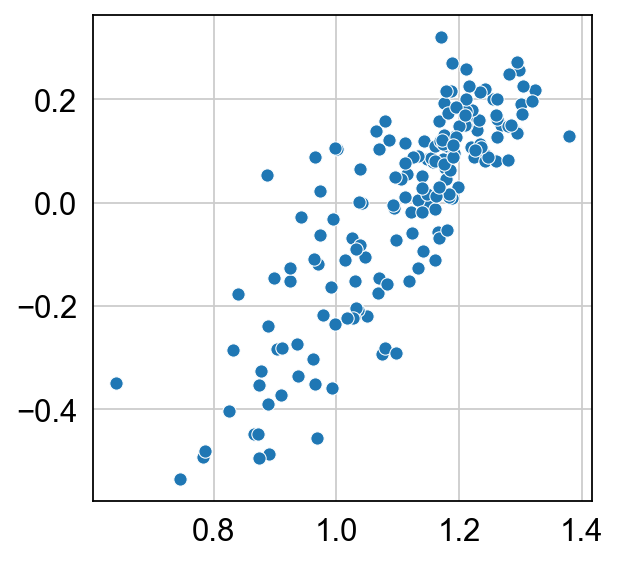

In [433]:
tcga_expr.obs['linclass7'] = calculate_lasso_score(tcga_expr, lsc16_genes, lasso.coef_)
sns.scatterplot(tcga_expr.obs['linclass7'].values, tcga_expr.obs['PC2'].values)
print("pearson =", tcga_expr.obs[['PC2', 'linclass7']].corr().values[0,1])

pearson = 0.8170966623365873


/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


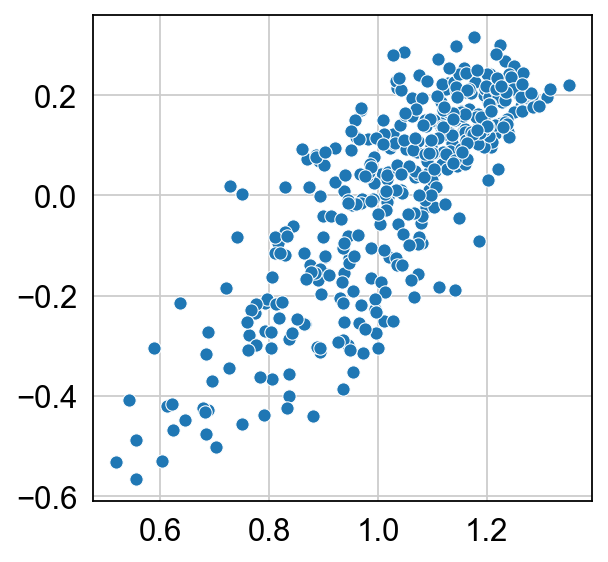

In [434]:
leuc_expr.obs['linclass7'] = calculate_lasso_score(leuc_expr, lsc16_genes, lasso.coef_)
sns.scatterplot(leuc_expr.obs['linclass7'].values, leuc_expr.obs['PC2'].values)
print("pearson =", leuc_expr.obs[['PC2', 'linclass7']].corr().values[0,1])

### Validation: BEAT-AML

pearson = 0.810983925970669


/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


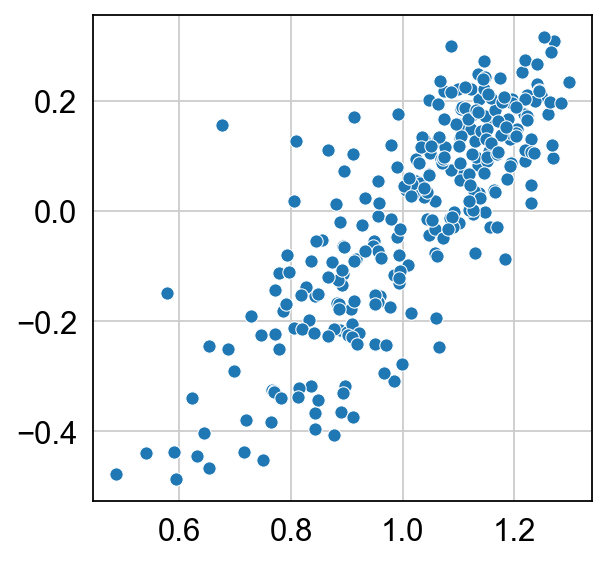

In [435]:
beat_expr.obs['linclass7'] = calculate_lasso_score(beat_expr, lsc16_genes, lasso.coef_)
sns.scatterplot(beat_expr.obs['linclass7'].values, beat_expr.obs['PC2'].values)
print("pearson =", beat_expr.obs[['PC2', 'linclass7']].corr().values[0,1])

In [436]:
# annotate with linclass7 scores to visualize across hierarchies
cat.obs = cat.obs.join(tcga_expr.obs[['linclass7']].append(beat_expr.obs[['linclass7']]).append(leuc_expr.obs[['linclass7']]))

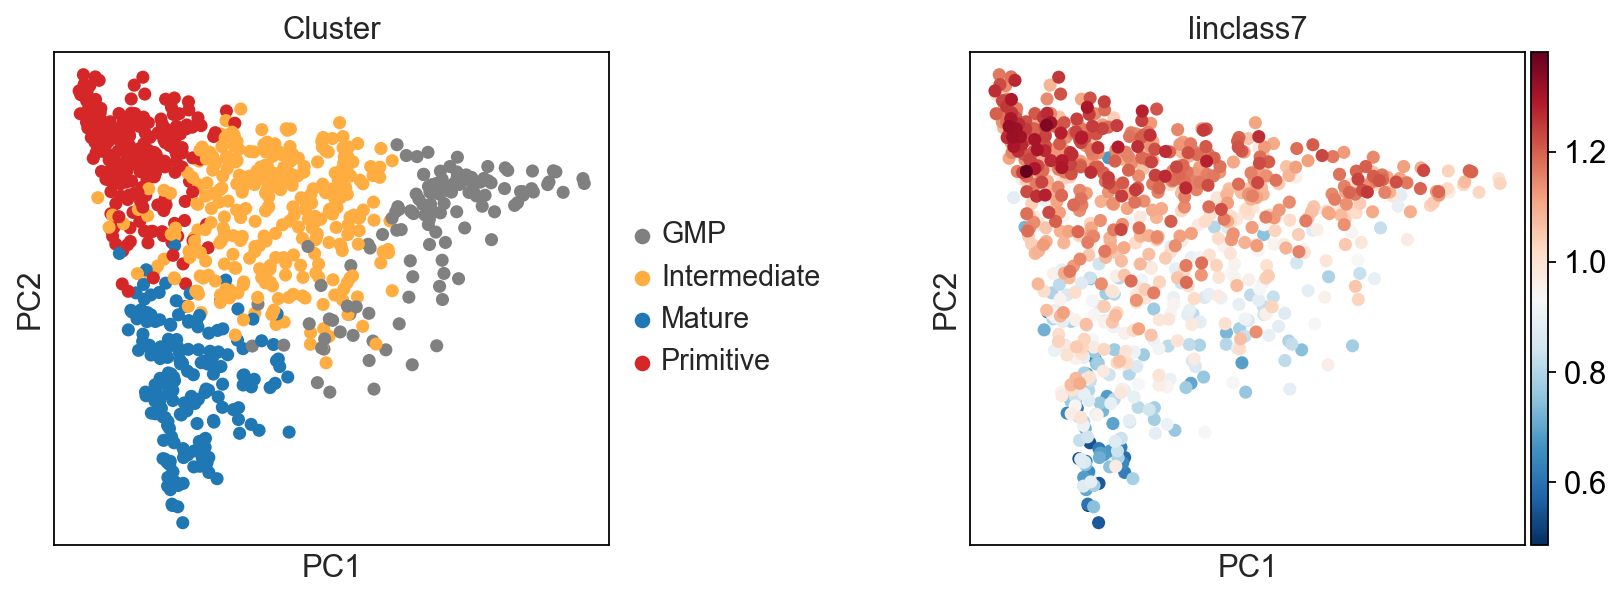

In [437]:
sc.pl.pca(cat, color=['Cluster', 'linclass7'], wspace=0.5, cmap='RdBu_r')

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


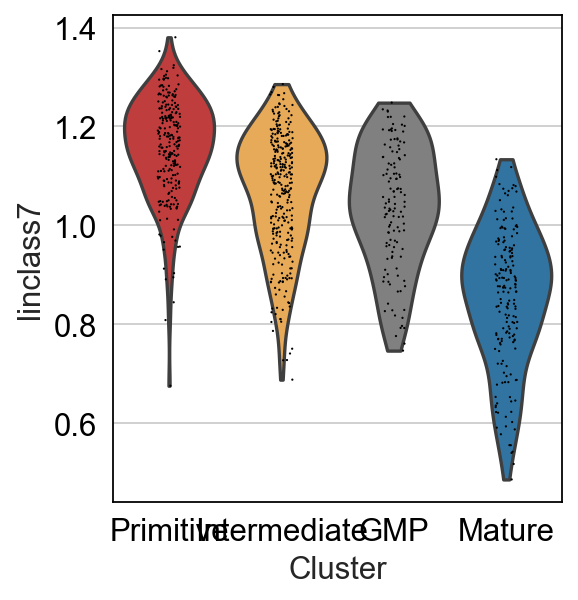

In [438]:
sc.pl.violin(cat, keys=['linclass7'], groupby='Cluster', order=['Primitive', 'Intermediate', 'GMP', 'Mature'])

# LinClass 7 Evaluation

In [7]:
linclass7 = pd.DataFrame([['CDK6', 'DNMT3B', 'CPXM1', 'GPR56', 'LAPTM4B', 'NGFRAP1', 'CD34'], 
                          [0.102538, 0.035447, 0.030578, 0.014235, 0.010607, 0.010586, 0.006118]], index=['Gene', 'Score']).T
linclass7

,Gene,Score
0,CDK6,0.102538
1,DNMT3B,0.035447
2,CPXM1,0.030578
3,GPR56,0.014235
4,LAPTM4B,0.010607
5,NGFRAP1,0.010586
6,CD34,0.006118


## Drug Correlations

### BEAT

In [480]:
# Get drug response data (AUC)
drug_responses = pd.read_csv(lab_path+"CIBERSORT/BEAT_AML/data/BEAT_AML_DrugResponses.csv")
beat_drug = cat[cat.obs['Cohort'] == "BEAT"]
drug_responses = drug_responses[drug_responses.lab_id.isin(beat_drug.obs.index.values)].drop(columns=['ic50', 'family']).pivot(index='lab_id', columns='inhibitor', values='auc')

# combine into new anndata object with drug response
beat_drug = ad.AnnData(X = drug_responses, obs = beat_drug[beat_drug.obs.index.isin(drug_responses.index.values)].obs)

# add linclass7 scores
expr = sc.read_csv(lab_path+"CIBERSORT/BEAT_AML/BEAT_AML_TPM.txt", delimiter='\t').T
expr.obs['linclass7'] = calculate_lasso_score(expr, linclass7['Gene'], linclass7['Score'])
beat_drug.obs = beat_drug.obs.join(expr.obs[['linclass7']])
beat_drug

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 202 × 122
    obs: 'Cohort', 'Cluster', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3', 'GMP-like', 'LSPC-Cycle', 'LSPC-Primed', 'LSPC-Quiescent', 'Mono-like', 'ProMono-like', 'cDC-like', 'linclass7'

### Pearson Correlation

In [481]:
from statsmodels.stats import multitest

def drug_obs_correlations_pearson(adata, obs):

    correlations = pd.DataFrame(columns=['pearson', 'pvalue'])

    for drug in adata.var_names:
        temp = pd.DataFrame({'score' : adata.obs[obs], 'auc' : adata[:,adata.var_names == drug].X.toarray().flatten()}).dropna()
        data = pd.DataFrame(np.asarray(scipy.stats.pearsonr(temp['score'], temp['auc'])), index=['pearson', 'pvalue'], columns=[drug]).T
        correlations = correlations.append(data)

    correlations['qvalue'] = multitest.multipletests(correlations.pvalue, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
    correlations.index.name = "Drug"
    correlations['score'] = obs

    return(correlations.sort_values('pvalue'))

In [482]:
%%capture --no-display

beat_scores = drug_obs_correlations_pearson(beat_drug, 'linclass7')

beat_scores['-log10(pvalue)'] = -np.log10(beat_scores['pvalue'])
beat_scores['-log10(FDR)'] = -np.log10(beat_scores['qvalue'])
beat_scores['|pearson|'] = np.abs(beat_scores['pearson'])

In [484]:
drug_beat = beat_scores.reset_index()
drug_beat['Drug'] = [x[0] for x in drug_beat['Drug'].str.split(' \(')]

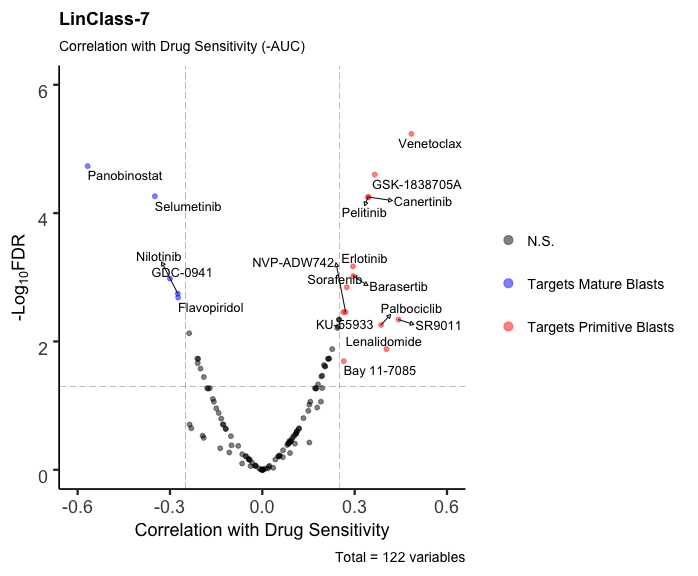

In [487]:
%%R -i drug_beat -w 9.7 -h 8 --units in

library(tidyverse)
library(EnhancedVolcano)

#names <- c('Tipifarnib', 'BAY 11-7082', 'Azacitidine', 'Mubritinib', 'BAY 11-7085', 'ABT-263', 'PD0332991', 'Decitabine', 'Erlotinib HCl', 'Fenretinide', 'Rapamycin', 'Temsirolimus', 'Everolimus', 'PKI-587')
#names <- c('Tipifarnib', 'Azacitidine', 'Mubritinib', 'ABT-263', 'PD0332991', 'Decitabine', 'Erlotinib HCl', 'Rapamycin', 'Temsirolimus', 'Everolimus', 'PKI-587')

scores <- drug_beat %>% filter(score == 'linclass7')

keyvals <- ifelse((scores$pearson < -0.25) & (scores$qvalue < 0.05), 'red',
      ifelse((scores$pearson > 0.25) & (scores$qvalue < 0.05), 'blue', 'black'))
keyvals[is.na(keyvals)] <- 'black'
names(keyvals)[keyvals == 'red'] <- '\nTargets Primitive Blasts\n'
names(keyvals)[keyvals == 'black'] <- '\nN.S.\n'
names(keyvals)[keyvals == 'blue'] <- '\nTargets Mature Blasts\n'

p <- scores %>% 
    mutate(pearson = -pearson) %>% 
    EnhancedVolcano(
        lab = scores$Drug,labSize = 4.5,
        #selectLab = names,labSize = 4,
        x = 'pearson', xlab = 'Correlation with Drug Sensitivity',
        y = 'qvalue', ylab = expression('-Log'[10]*'FDR'),
        colCustom = keyvals,
        drawConnectors = TRUE, 
        xlim = c(-0.6, 0.6), ylim = c(0,6),
        pCutoff = 0.05, FCcutoff = 0.25, 
        cutoffLineWidth = 0.15,
        gridlines.major = FALSE,
        gridlines.minor = FALSE,
        title = "LinClass-7",
        subtitle = "Correlation with Drug Sensitivity (-AUC)",
        legendPosition = 'right')
    
p

## Lee et al

In [9]:
expr = sc.read_csv("Data/Fig4_DrugResponse_LinClass7/Lee2018_30pt_array.csv").T#.dropna().set_index('Gene')
expr = expr[:,expr.var_names != "NA"]
drugAUC = sc.read_csv("Data/Fig4_DrugResponse_LinClass7/Lee2018_30pt_DrugAUC.csv").T

expr.obs['linclass7'] = calculate_lasso_score(expr, linclass7['Gene'], linclass7['Score'])
drugAUC.obs = expr.obs

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


### Pearson Correlations

In [490]:
lee_scores = drug_obs_correlations_pearson(drugAUC, 'linclass7')

lee_scores['-log10(pvalue)'] = -np.log10(lee_scores['pvalue'])
lee_scores['-log10(FDR)'] = -np.log10(lee_scores['qvalue'])
lee_scores['|pearson|'] = np.abs(lee_scores['pearson'])
lee_scores

,pearson,pvalue,qvalue,score,-log10(pvalue),-log10(FDR),|pearson|
Drug,,,,,,,
Tipifarnib,-0.713369,0.000010,0.001534,linclass7,5.015454,2.814057,0.713369
BAY 11-7082,-0.660336,0.000072,0.004215,linclass7,4.144980,2.375169,0.660336
Azacitidine,-0.657244,0.000080,0.004215,linclass7,4.099445,2.375169,0.657244
MLN8237,-0.636357,0.000157,0.005940,linclass7,3.804724,2.226184,0.636357
Rapamycin,0.624765,0.000224,0.005940,linclass7,3.650275,2.226184,0.624765
...,...,...,...,...,...,...,...
PI-103,0.060864,0.749348,0.768686,linclass7,0.125316,0.114251,0.060864
OSI-027,0.040905,0.830067,0.846030,linclass7,0.080887,0.072614,0.040905
AZD7762,0.032055,0.866463,0.877501,linclass7,0.062250,0.056753,0.032055


In [491]:
drug_df = lee_scores.reset_index()

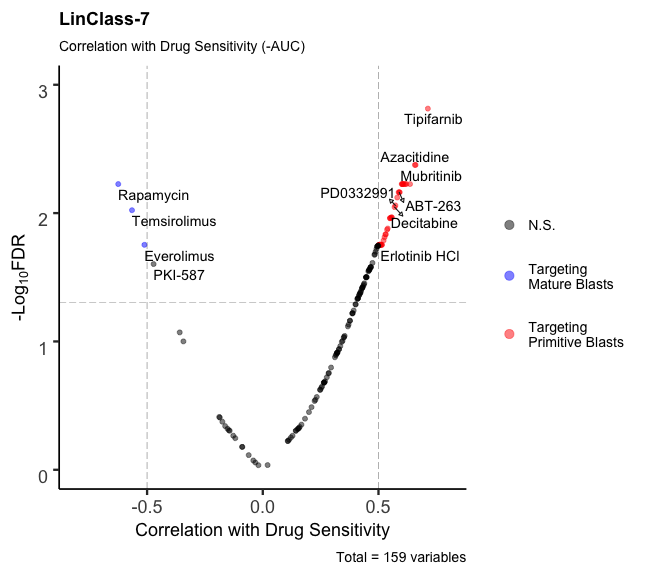

In [492]:
%%R -i drug_df -w 9 -h 8 --units in

library(tidyverse)
library(EnhancedVolcano)

#names <- c('Tipifarnib', 'BAY 11-7082', 'Azacitidine', 'Mubritinib', 'BAY 11-7085', 'ABT-263', 'PD0332991', 'Decitabine', 'Erlotinib HCl', 'Fenretinide', 'Rapamycin', 'Temsirolimus', 'Everolimus', 'PKI-587')
names <- c('Tipifarnib', 'Azacitidine', 'Mubritinib', 'ABT-263', 'PD0332991', 'Decitabine', 'Erlotinib HCl', 'Rapamycin', 'Temsirolimus', 'Everolimus', 'PKI-587')

keyvals <- ifelse((drug_df$pearson < -0.5) & (drug_df$qvalue < 0.05), 'red',
      ifelse((drug_df$pearson > 0.5) & (drug_df$qvalue < 0.05), 'blue', 'black'))
keyvals[is.na(keyvals)] <- 'black'
names(keyvals)[keyvals == 'red'] <- '\nTargeting\nPrimitive Blasts\n'
names(keyvals)[keyvals == 'black'] <- '\nN.S.\n'
names(keyvals)[keyvals == 'blue'] <- '\nTargeting\nMature Blasts\n'

p <- drug_df %>% 
    mutate(pearson = -pearson) %>% 
    EnhancedVolcano(
        lab = drug_df$Drug,
        selectLab = names,labSize = 5,
        x = 'pearson', xlab = 'Correlation with Drug Sensitivity',
        y = 'qvalue', ylab = expression('-Log'[10]*'FDR'),
        colCustom = keyvals,
        drawConnectors = TRUE, 
        xlim = c(-0.8, 0.8), ylim = c(0,3),
        pCutoff = 0.05, FCcutoff = 0.5, 
        cutoffLineWidth = 0.15,
        gridlines.major = FALSE,
        gridlines.minor = FALSE,
        title = "LinClass-7",
        subtitle = "Correlation with Drug Sensitivity (-AUC)",
        legendPosition = 'right')
    
p

## Split patients by LinClass-7 and compare drug sensitivity

Depict sensitivity using scaled -AUC values

In [11]:
from seaborn.categorical import _ViolinPlotter

class MyVPlot(_ViolinPlotter):
    def draw_quartiles(self, ax, data, support, density, center, split=False):
        """Draw the quartiles as lines at width of density."""
        q25, q50, q75 = np.percentile(data, [25, 50, 75])
        self.draw_to_density(ax, center, q50, support, density, split,
                             linewidth=self.linewidth, )

def my_violinplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
                  bw="scott", cut=2, scale="area", scale_hue=True, gridsize=100,
                  width=.8, inner="box", split=False, dodge=True, orient=None,
                  linewidth=None, color=None, palette=None, saturation=.75,
                  ax=None, **kwargs):
    plotter = MyVPlot(x, y, hue, data, order, hue_order,
                      bw, cut, scale, scale_hue, gridsize,
                      width, inner, split, dodge, orient, linewidth,
                      color, palette, saturation)
    if ax is None:
        ax = plt.gca()
    plotter.plot(ax)
    return ax

def violin_category(data, category, score, xlab = None, ylab = None, order=["Low", "High"], boxpairlist=[("Low", "High")], textformat = "star", swarm=True, swarmsize=5):
    data = data.obs
    p1 = my_violinplot(data = data, x = category, y = score, scale='width', order=order, inner="quartile")
    if swarm==True:
        p1 = sns.swarmplot(data = data, x = category, y = score, order=order, color="black", size = swarmsize)
    add_stat_annotation(p1, data=data, x= category, y= score, order=order, box_pairs=boxpairlist,
                        test='t-test_ind', text_format= textformat, loc='outside', verbose=0)
    if xlab != None:
        plt.xlabel(xlab)
    if ylab != None:
        plt.ylabel(ylab)
    sns.despine()

In [493]:
beat_drug.obs['LinClass-7 Category'] = np.where(beat_drug.obs['linclass7'] > np.median(beat_drug.obs['linclass7']), 'LinClass-7 High\nPrimitive', 'LinClass-7 Low\nMature')

In [548]:
%%capture 
from sklearn.preprocessing import scale
beat_drug.obs['Venetoclax Sensitivity'] = scale(-beat_drug[:, 'Venetoclax'].X.toarray().flatten())
beat_drug.obs['Palbociclib Sensitivity'] = scale(-beat_drug[:, 'Palbociclib'].X.toarray().flatten())
beat_drug.obs['Selumetinib Sensitivity'] = scale(-beat_drug[:, 'Selumetinib (AZD6244)'].X.toarray().flatten())
beat_drug.obs['Panobinostat Sensitivity'] = scale(-beat_drug[:, 'Panobinostat'].X.toarray().flatten())

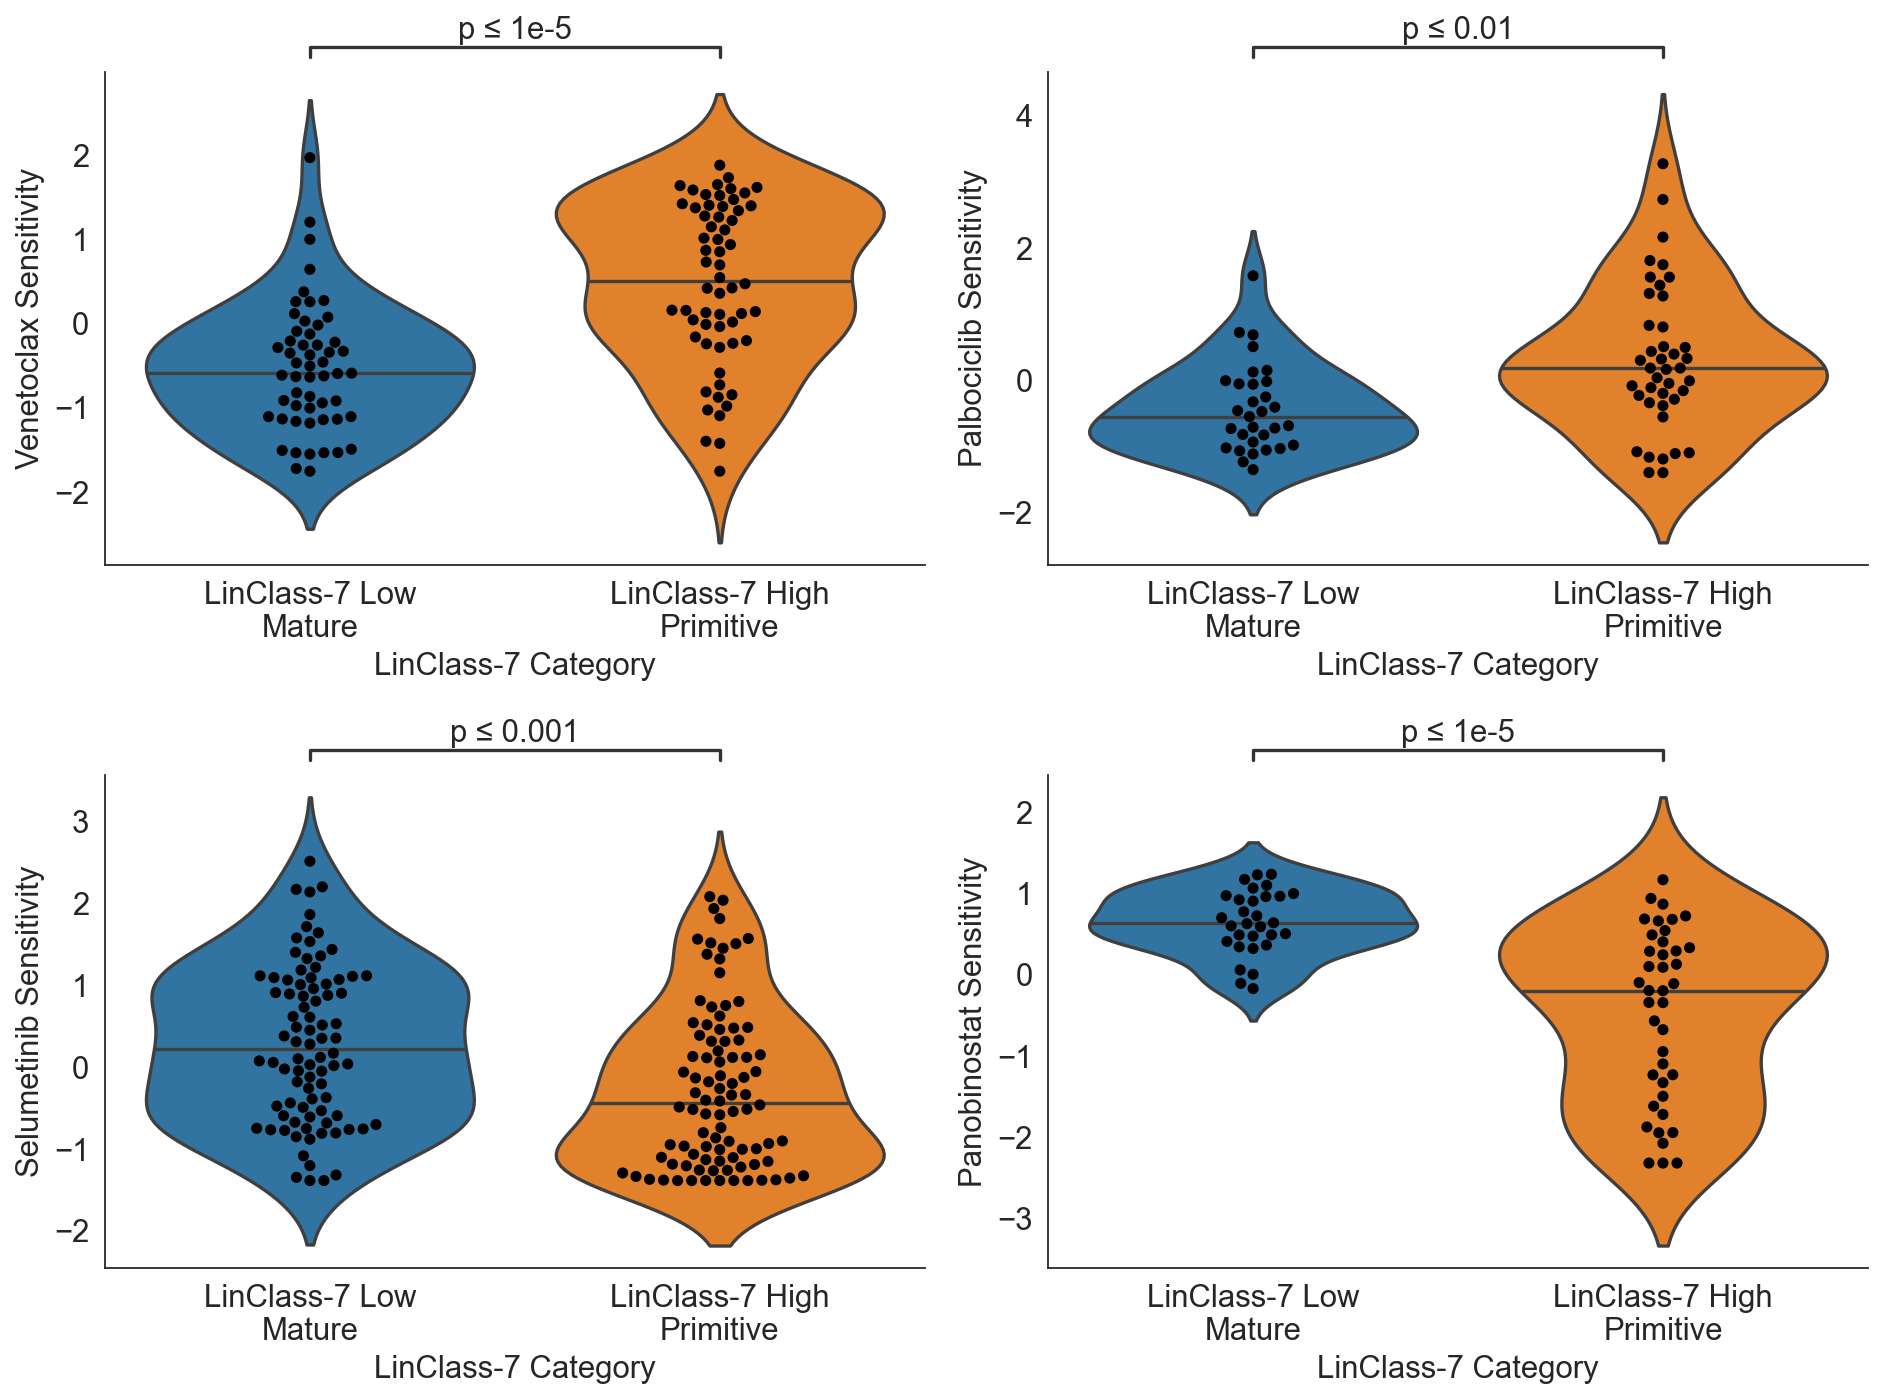

In [549]:
sns.set_style('white')
plt.figure(figsize=[12, 9])

plt.subplot(2,2,1)
violin_category(beat_drug, 'LinClass-7 Category', 'Venetoclax Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.subplot(2,2,2)
violin_category(beat_drug, 'LinClass-7 Category', 'Palbociclib Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.subplot(2,2,3)
violin_category(beat_drug, 'LinClass-7 Category', 'Selumetinib Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.subplot(2,2,4)
violin_category(beat_drug, 'LinClass-7 Category', 'Panobinostat Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')

plt.tight_layout()

In [567]:
%%capture 
drugAUC.obs['Navitoclax Sensitivity'] = scale(-drugAUC[:, 'ABT-263'].X.toarray().flatten())
drugAUC.obs['Mubritinib Sensitivity'] = scale(-drugAUC[:, 'Mubritinib'].X.toarray().flatten())
drugAUC.obs['Temsirolimus Sensitivity'] = scale(-drugAUC[:, 'Temsirolimus'].X.toarray().flatten())
drugAUC.obs['Azacitidine Sensitivity'] = scale(-drugAUC[:, 'Azacitidine'].X.toarray().flatten())

In [569]:
drugAUC.obs['LinClass-7 Category'] = np.where(drugAUC.obs['linclass7'] > np.median(drugAUC.obs['linclass7']), 'LinClass-7 High\nPrimitive', 'LinClass-7 Low\nMature')

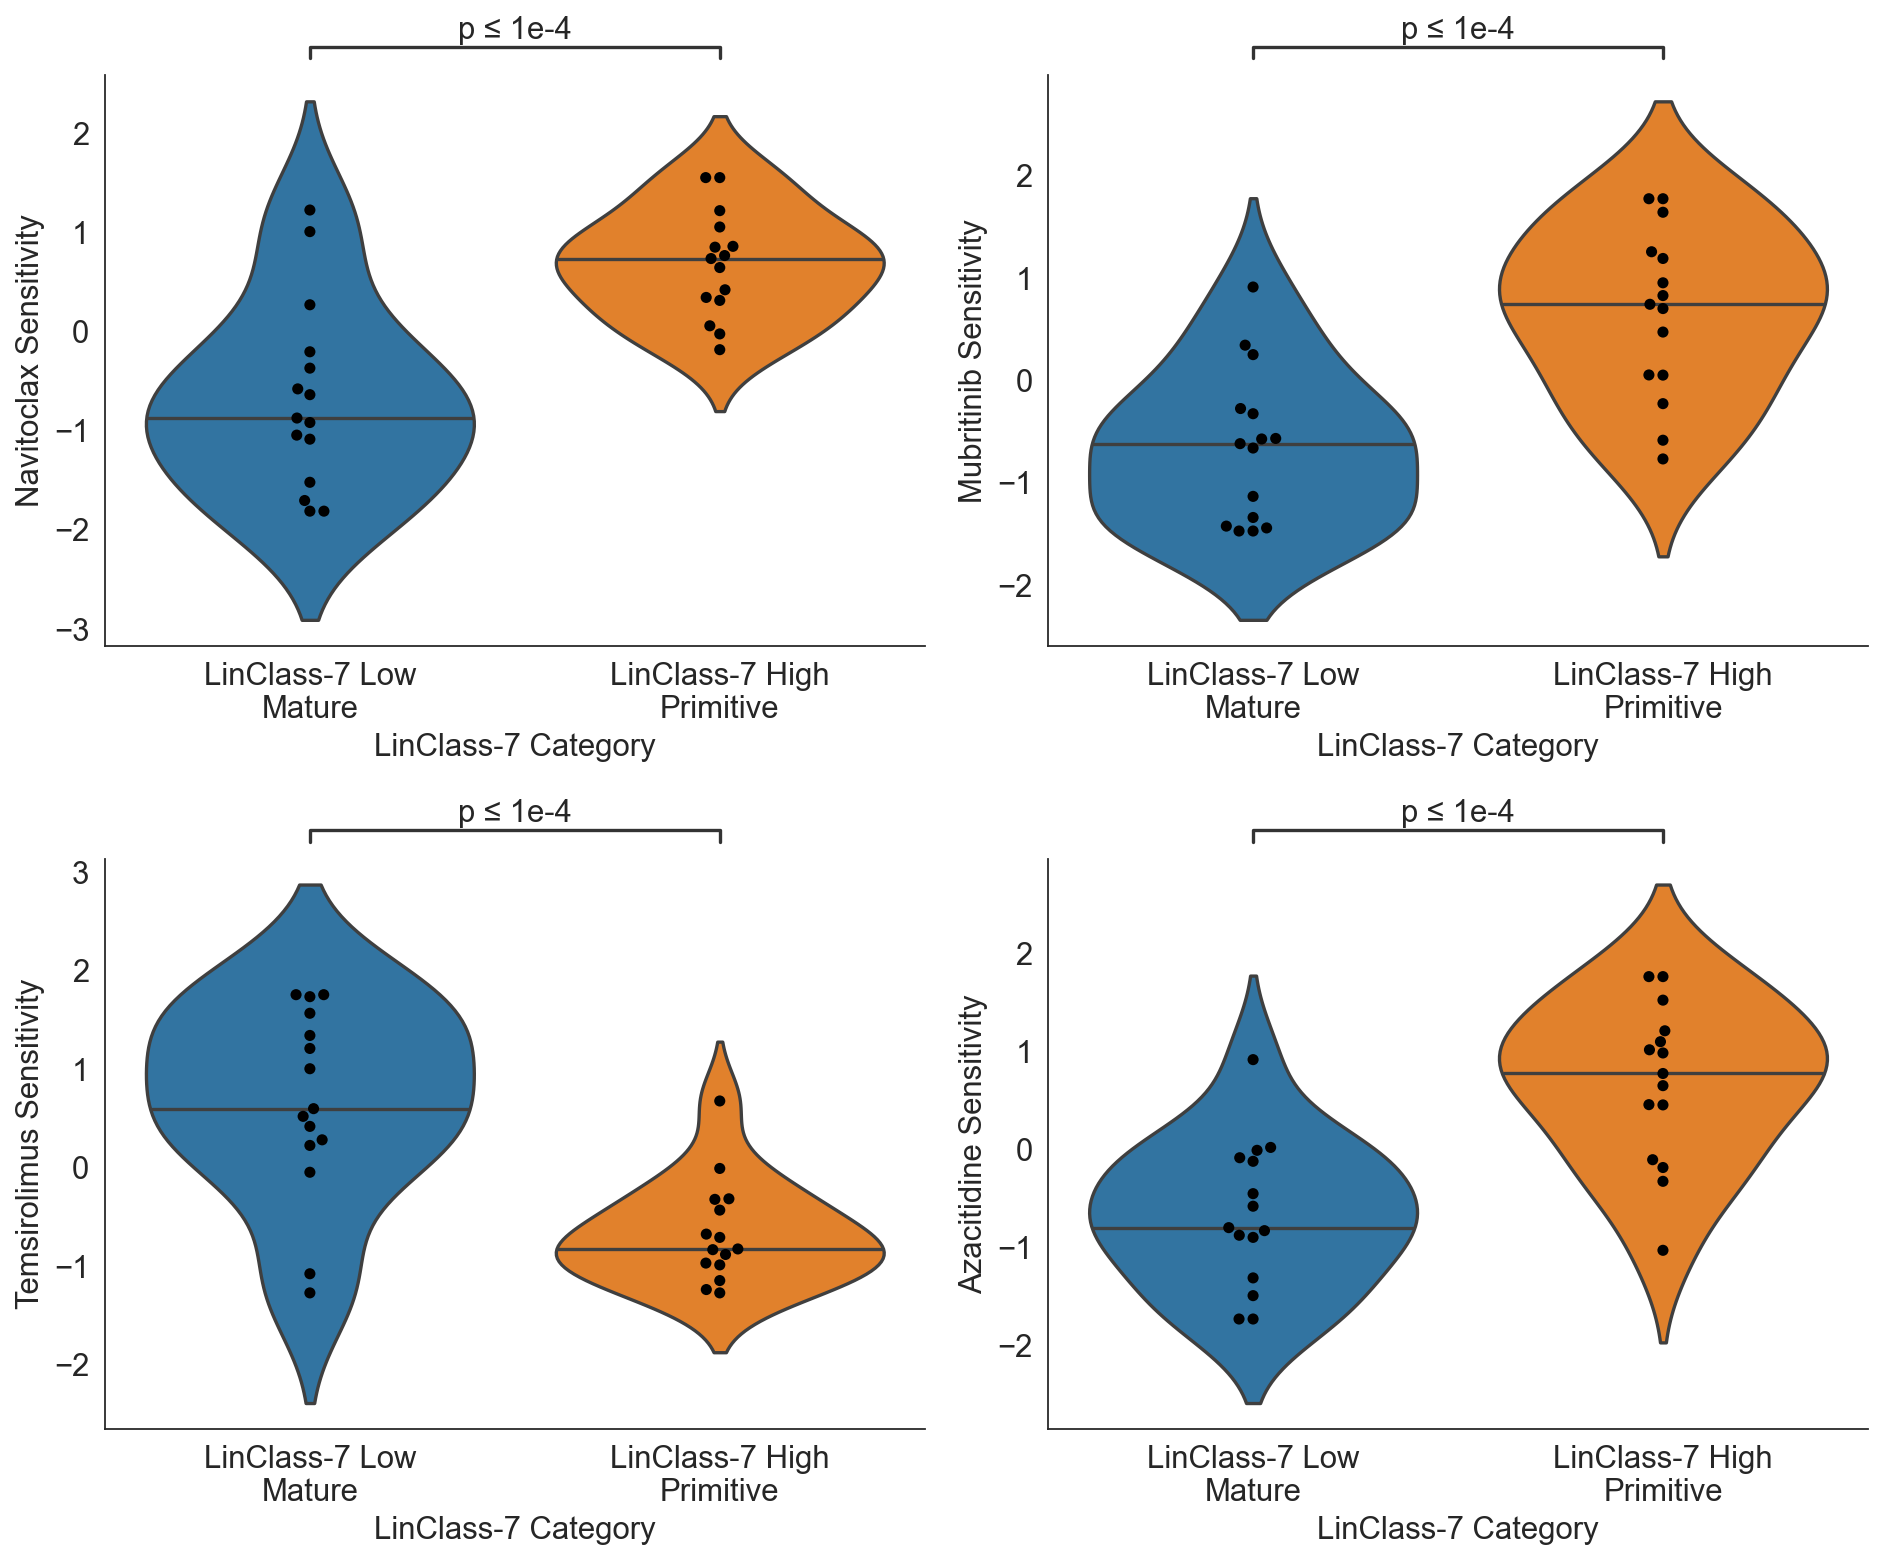

In [570]:
plt.figure(figsize=[12, 10])
plt.subplot(2,2,1)
violin_category(drugAUC, 'LinClass-7 Category', 'Navitoclax Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.subplot(2,2,2)
violin_category(drugAUC, 'LinClass-7 Category', 'Mubritinib Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.subplot(2,2,3)
violin_category(drugAUC, 'LinClass-7 Category', 'Temsirolimus Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.subplot(2,2,4)
violin_category(drugAUC, 'LinClass-7 Category', 'Azacitidine Sensitivity', 
                   order=['LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive'], boxpairlist=[('LinClass-7 Low\nMature', 'LinClass-7 High\nPrimitive')], textformat='simple')
plt.tight_layout()

# Myelotarg

In [10]:
myelotarg = pd.read_csv("Data/Fig4_DrugResponse_LinClass7/mylotarg.array.txt", delimiter='\t').set_index("ID").T
myelotarg.index.rename('patientID', inplace=True)
anno = pd.read_csv("Data/Fig4_DrugResponse_LinClass7/mylotarg.clinical.txt", delimiter='\t').set_index('patientID')
anno.index = anno.index.map(str)
mytarg = ad.AnnData(X=myelotarg, obs=anno)
for ob in ['male', 'codealfa', 'npm1', 'flt3itd', 'efsevent', 'relapse', 'osi']:
    mytarg.obs[ob] = mytarg.obs[ob].astype('str')

In [583]:
mytarg.obs['linclass7'] = calculate_lasso_score(mytarg, linclass7['Gene'], linclass7['Score'])
mytarg

AnnData object with n_obs × n_vars = 192 × 17693
    obs: 'arm', 'age', 'male', 'wbc', 'codealfa', 'npm1', 'flt3itd', 'response', 'efsd', 'efsevent', 'rfsd', 'relapse', 'os', 'osi', 'CDK6', 'DNMT3B', 'CPXM1', 'GPR56', 'LAPTM4B', 'NGFRAP1', 'CD34', 'linclass7'

In [584]:
mytarg.obs['LinClass7_cat'] = np.where(mytarg.obs['linclass7'] > np.median(mytarg.obs['linclass7']), 'High', 'Low')

In [586]:
mytarg_scores = mytarg.obs.astype('str')

## Survival

In [587]:
%%R

get_survplot <- function(fit, cat_name, studyname, subset="", survtype = 'Overall', labels = FALSE, label_values){
    if(labels == TRUE){
        # Drawing curves
        gg <- ggsurvplot(fit, title = paste0(survtype, " Survival by ", cat_name, " ", subset, "\n"),
                   font.title = 17, font.x =  15,
                   font.y = 15, font.tickslab = 13, 
                   xscale = 'd_y', break.time.by=365.1,
                   legend.title = cat_name, legend.labs = label_values, 
                   palette = 'Dark2', pval = TRUE, 
                   #conf.int = TRUE, conf.int.style = "step", 
                   risk.table = TRUE, risk.table.y.text.col = TRUE,
                   risk.table.col = 'strata', risk.table.height = 0.2, 
                   ncensor.plot = FALSE, ncensor.plot.height = 0.15)
    }else{
        # Drawing curves
        gg <- ggsurvplot(fit, title = paste0(survtype, " Survival by ", cat_name, " ", subset, "\n"),
                   font.title = 17, font.x =  15,
                   font.y = 15, font.tickslab = 13, 
                   xscale = 'd_y', break.time.by=365.1,
                   legend.title = cat_name, 
                   palette = 'Dark2', pval = TRUE, 
                   #conf.int = TRUE, conf.int.style = "step", 
                   risk.table = TRUE, risk.table.y.text.col = TRUE,
                   risk.table.col = 'strata', risk.table.height = 0.2, 
                   ncensor.plot = FALSE, ncensor.plot.height = 0.15)
    }
    
    #ggsave(paste0("primscore/figures/", studyname, "_", subset, "_by_", cat_name, "_", survtype, "_Survival", ".png"), print(gg), width = 8, height = 10, dpi = 'retina')
    print(gg)
}

plot_mylotarg_survival <- function(subset=""){
    
    survfit(Surv(os, osi) ~ arm, data = dat, type = 'kaplan-meier') %>% 
        get_survplot(., "Treatment Arm", "ALFA-0701", subset, survtype='Overall', labels=TRUE, label_values=c("control", "GO"))

    survfit(Surv(efsd, efsevent) ~ arm, data = dat, type = 'kaplan-meier') %>% 
        get_survplot(., "Treatment Arm", "ALFA-0701", subset, survtype='Event-Free', labels=TRUE, label_values=c("control", "GO"))

    survfit(Surv(rfsd, relapse) ~ arm, data = dat, type = 'kaplan-meier') %>% 
        get_survplot(., "Treatment Arm", "ALFA-0701", subset, survtype='Relapse-Free', labels=TRUE, label_values=c("control", "GO"))
}


### Chemo vs Chemo + GO: all patients

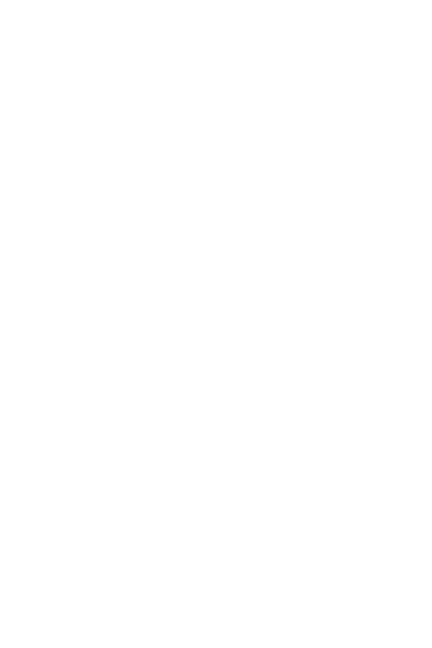

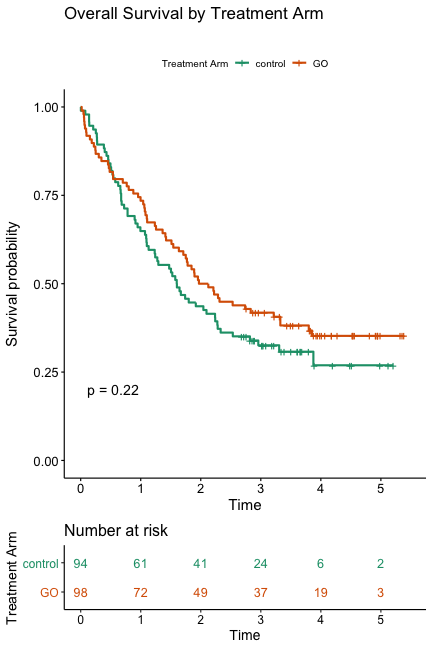

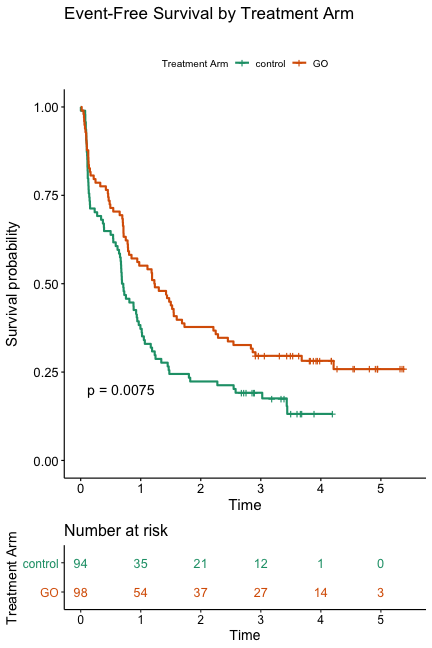

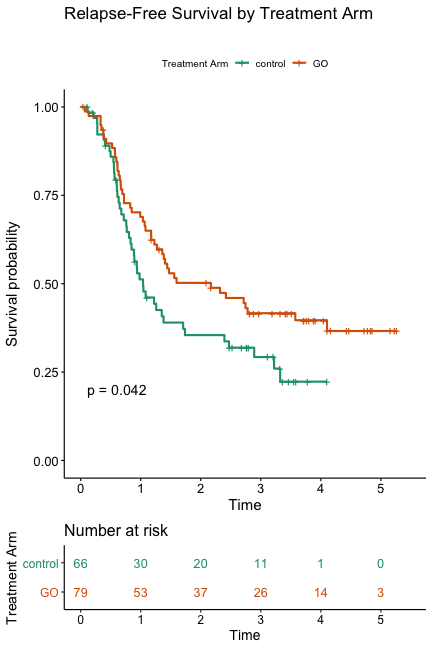

In [588]:
%%R -i mytarg_scores -w 6 -h 9 --units in

mytarg <- mytarg_scores %>% mutate_each_(funs(as.numeric), c("age", "wbc", "efsd", "efsevent", "rfsd", "relapse", "os", "osi"))

dat <- mytarg
plot_mylotarg_survival()

### Subgroup analysis: stratify by LinClass7

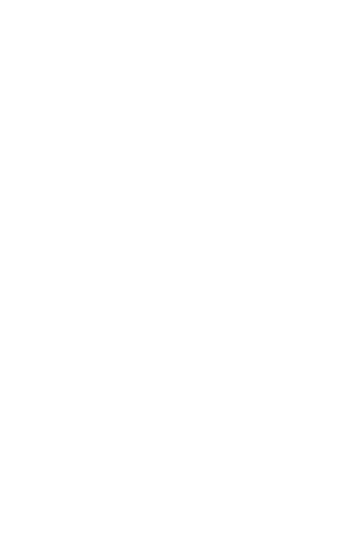

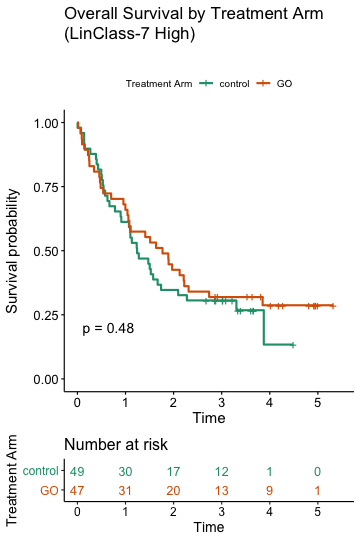

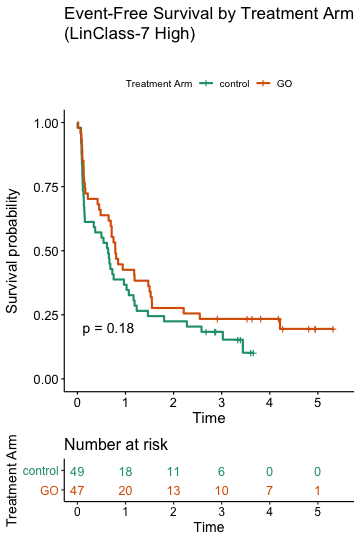

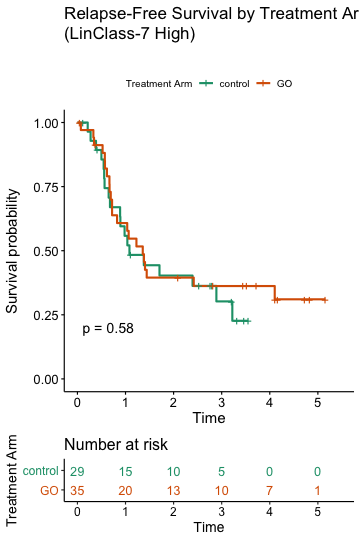

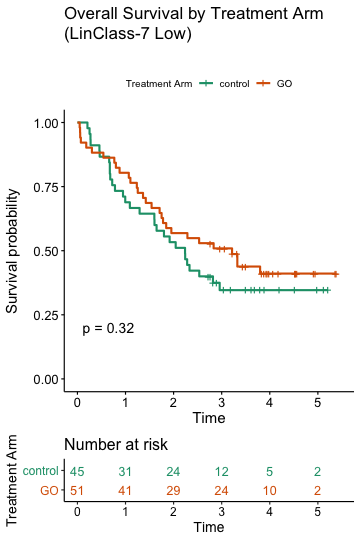

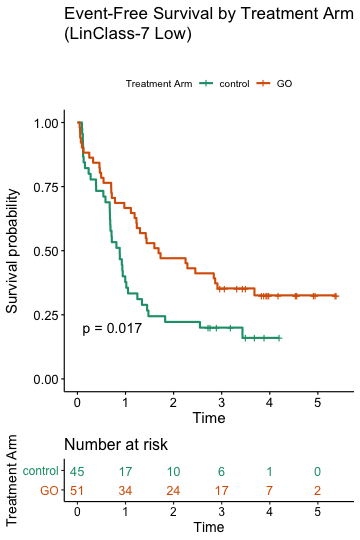

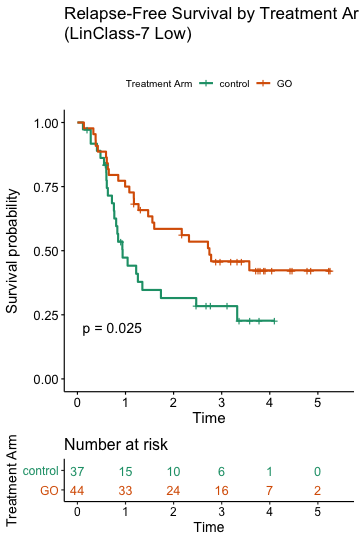

In [589]:
%%R -w 5 -h 7.5 --units in
linclass7_hi <- mytarg %>% filter(LinClass7_cat == "High")
linclass7_lo <- mytarg %>% filter(LinClass7_cat == "Low")

dat <- linclass7_hi
plot_mylotarg_survival(subset = "\n(LinClass-7 High)")

dat <- linclass7_lo
plot_mylotarg_survival(subset = "\n(LinClass-7 Low)")